In [1]:
import pandas as pd
import os

In [10]:
df = pd.read_csv(os.getcwd()+"/data/hour.csv")

In [8]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [9]:
df.shape

(17379, 17)

# Plotting a diagonal correlation matrix
Source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html?highlight=correlation%20matrix

In [20]:
%matplotlib inline

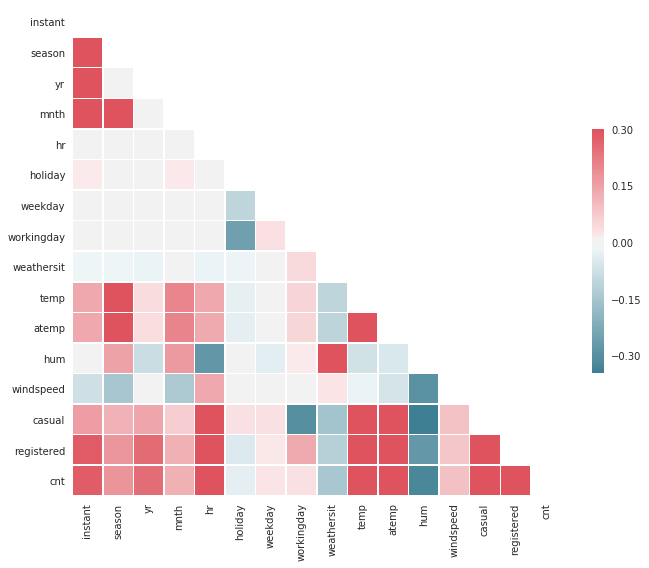

In [21]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Train-Test-Split

In [103]:
# not using columns #1 (instant = record idx) and #2 (dteday = date) as predictors
X, y = df_train[["yr","mnth","hr","holiday","weekday","workingday","weathersit","temp","hum","windspeed"]], df_train.cnt

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# it is best to apply ridge regression after standardizing the predictors!
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

"Very often, the independent variables are centered and scaled in order to have variance 1."  
(Source: https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression) 


# Ridge regression

In [111]:
from sklearn import linear_model
reg = linear_model.Ridge (alpha = .5)
reg.fit(X_train, y_train) 

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [112]:
print(reg.coef_)
print(reg.intercept_)

[ 40.70732104  17.64479331  53.15981537  -3.7280205    5.44566529
   2.50122459  -2.21486175  56.48900582 -36.64036248   0.96469303]
188.973401535


In [113]:
from sklearn.metrics import mean_squared_error 
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred)

20145.726510152588

In [114]:
from sklearn.metrics import r2_score
r2_score(y_train, reg.predict(X_train))

0.37039169258051163

# Ridge regression - cross validated automatically

In [116]:
from sklearn import linear_model
rcv = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
rcv.fit(X_train, y_train)
rcv.alpha_                                      

10.0

In [117]:
y_pred = rcv.predict(X_test)
mean_squared_error(y_test, y_pred)

20146.225189886038

In [118]:
from sklearn.metrics import r2_score
r2_score(y_train, rcv.predict(X_train))

0.370391446794891

# Ridge Regression - cross validated manually
Source: https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/

In [122]:
from sklearn.model_selection import cross_val_score

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

val_errors = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=.5, random_state=42)
    errors = np.sum(-cross_val_score(ridge, 
                                     X_train, 
                                     y=y_train, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10, 
                                     n_jobs=-1))
    val_errors.append(np.sqrt(errors))

Let’s checkout the validation errors associated with each alpha.

In [127]:
# RMSE
print(val_errors)

[455.05797081897452, 455.05797081897452, 455.05797081897452, 455.05797081897452, 455.05797081897452, 455.05797081897452]


Which value of alpha gave us the smallest validation error?

In [128]:
print('best alpha: {}'.format(alphas[np.argmin(val_errors)]))

best alpha: 0.0001


# Plot Ridge coefficients as a function of the regularization
Source: http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py

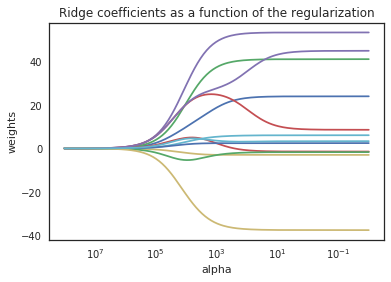

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-2, 8, n_alphas)

coefs = []
for a in alphas:
    #ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Further Soruces:
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html  
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/  
https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b  
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html